In [2]:
import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'white'
import pandas as pd
import matplotlib.pyplot as plt
from dataset import *
from evaluation import *
from train import *
from models import *

from transformers import logging
logging.set_verbosity_error()
import warnings
warnings.filterwarnings('ignore')

## 一. Data inspection: 检查distribution

<AxesSubplot:xlabel='label'>

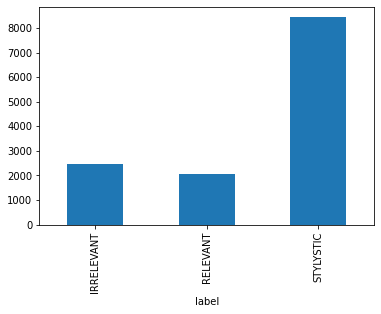

In [2]:
datapath = '../generated_data/similar_sentences_large.xlsx'
df = pd.read_excel(datapath)
df.groupby(['label']).size().plot.bar()

In [3]:
df['label'].value_counts()

STYLYSTIC     8430
IRRELEVANT    2469
RELEVANT      2069
Name: label, dtype: int64

## 二. bert tokenizer demo

In [ ]:
from transformers import BertTokenizer
from transformers import RobertaTokenizer
#tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
example_text = 'I will watch Memento tonight'
bert_input = tokenizer(example_text, example_text ,padding='max_length', max_length = 20, 
                       truncation=True, return_tensors="pt")

In [ ]:
example_text = tokenizer.decode(bert_input.input_ids[0])
example_text

## 三. Data set: 数据集

In [3]:
train_dataloader, val_dataloader, test_dataloader = get_dataloader(df, tokenizer='bert-base-cased')

IRRELEVANT    1668
RELEVANT      1668
STYLYSTIC     1668
Name: label, dtype: int64
train: 5004 val: 1297 test: 1297


## 四. Model: 模型

In [4]:
# Load the model
#pretrain = 'nlpaueb/legal-bert-base-uncased'
pretrain = 'bert-base-uncased'
model = BertClassifier(pretrain = pretrain)
#model = RobertaClassifier()

## 五. Training: 训练

In [5]:
EPOCHS = 3
LR = 1e-6
              
train(model, train_dataloader, val_dataloader, LR, EPOCHS)

# Save the model
#model_name = 'roberta-base_{}.pt'.format(EPOCHS)
#model_name = 'legal-bert-base_{}.pt'.format(EPOCHS)
model_name = 'bert-base_{}.pt'.format(EPOCHS)
torch.save(model.state_dict(), 'models/' + model_name)

100%|██████████| 313/313 [01:50<00:00,  2.84it/s]


Epochs: 1 | Train Loss:  0.055                 | Train Accuracy:  0.640                 | Val Loss:  0.039                 | Val Accuracy:  0.843


100%|██████████| 313/313 [01:48<00:00,  2.88it/s]


Epochs: 2 | Train Loss:  0.036                 | Train Accuracy:  0.855                 | Val Loss:  0.028                 | Val Accuracy:  0.906


100%|██████████| 313/313 [01:49<00:00,  2.87it/s]


Epochs: 3 | Train Loss:  0.023                 | Train Accuracy:  0.931                 | Val Loss:  0.019                 | Val Accuracy:  0.931


## 六. Evaluation: 测试

In [6]:
# Load the model
model = BertClassifier(pretrain = pretrain)
#model = RobertaClassifier()
model.load_state_dict(torch.load('models/' + model_name))
evaluate(model, test_dataloader)

Test Accuracy:  0.938
Test F1:  0.886
Test Precision:  0.885
Test Recall:  0.911


In [8]:
train(model, train_dataloader, val_dataloader, LR, 6)

100%|██████████| 313/313 [01:48<00:00,  2.89it/s]


Epochs: 1 | Train Loss:  0.003                 | Train Accuracy:  0.991                 | Val Loss:  0.004                 | Val Accuracy:  0.981


100%|██████████| 313/313 [01:48<00:00,  2.89it/s]


Epochs: 2 | Train Loss:  0.002                 | Train Accuracy:  0.994                 | Val Loss:  0.006                 | Val Accuracy:  0.975


100%|██████████| 313/313 [01:48<00:00,  2.88it/s]


Epochs: 3 | Train Loss:  0.002                 | Train Accuracy:  0.995                 | Val Loss:  0.004                 | Val Accuracy:  0.978


100%|██████████| 313/313 [01:48<00:00,  2.89it/s]


Epochs: 4 | Train Loss:  0.001                 | Train Accuracy:  0.997                 | Val Loss:  0.004                 | Val Accuracy:  0.979


100%|██████████| 313/313 [01:48<00:00,  2.89it/s]


Epochs: 5 | Train Loss:  0.001                 | Train Accuracy:  0.996                 | Val Loss:  0.003                 | Val Accuracy:  0.981


100%|██████████| 313/313 [01:47<00:00,  2.90it/s]


Epochs: 6 | Train Loss:  0.001                 | Train Accuracy:  0.998                 | Val Loss:  0.004                 | Val Accuracy:  0.980


In [9]:
evaluate(model, test_dataloader)

Test Accuracy:  0.982
Test F1:  0.969
Test Precision:  0.966
Test Recall:  0.979


In [ ]:
torch.save(model.state_dict(), 'models/' + 'legal_bert_{}.pt'.format(10))

In [10]:
model_name = 'roberta-base_{}.pt'.format(10)
torch.save(model.state_dict(), 'models/' + model_name)